In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import datetime
import matplotlib.dates as mdates

In [16]:
filepath = "/Users/kassiewang/GitHub/cds/Kassie/422coronaclean.csv"
rawcorona = pd.read_csv(filepath, error_bad_lines=False)

cleancorona = rawcorona[rawcorona['Country.Region'].str.contains('US', case = True, regex = True)]
cleancorona.drop('Country.Region', 1, inplace = True)
cleancorona['ObservationDate'] = pd.to_datetime(cleancorona['ObservationDate'])
cleancorona.rename(columns = {'ObservationDate':'date'}, inplace = True)

b'Skipping line 3: expected 5 fields, saw 6\nSkipping line 625: expected 5 fields, saw 6\nSkipping line 626: expected 5 fields, saw 6\nSkipping line 627: expected 5 fields, saw 6\nSkipping line 2972: expected 5 fields, saw 6\nSkipping line 2973: expected 5 fields, saw 6\nSkipping line 2974: expected 5 fields, saw 6\nSkipping line 2975: expected 5 fields, saw 6\n'
/Users/kassiewang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/kassiewang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

In [17]:
rawtweets = pd.read_csv("/Users/kassiewang/GitHub/cds/final_csv/us.csv")
rawtweets = rawtweets.drop(rawtweets.columns[[0]], axis = 1)
rawtweets['Date'] = rawtweets['Date'].str[:10]
rawtweets['Date'] = pd.to_datetime(rawtweets['Date'], errors='coerce')
rawtweets.rename(columns = {'Date': 'date'}, inplace = True)

tweetct = rawtweets.groupby(['date']).agg('count')
tweetct.rename(columns = {'Text':'tweetct'}, inplace = True)

In [27]:
finaldf = pd.merge(tweetct, cleancorona, how='inner', on = 'date')
finaldf
finaldf.to_csv('/Users/kassiewang/GitHub/cds/final_csv/featureengFINAL.csv', index = False)

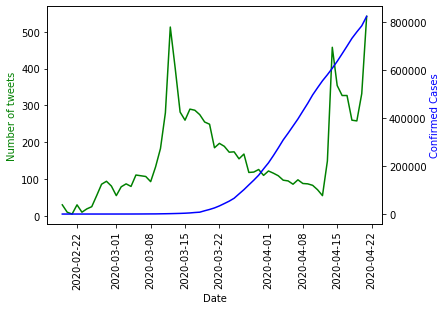

In [25]:
x = finaldf['date']
y1 = finaldf['tweetct']
y2 = finaldf['Confirmed']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Number of tweets', color='g')
ax2.set_ylabel('Confirmed Cases', color='b')

ax1.xaxis.set_tick_params(rotation=90)
plt.show()


In [26]:
from scipy.stats import pearsonr

corr, _ = pearsonr(finaldf['tweetct'], finaldf['Confirmed'])
print('Pearson: %.3f' % corr)


Pearson: 0.359


In [1]:
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import nltk
import re
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from itertools import islice
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
#nltk.download('stopwords')
#nltk.download('wordnet')

def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    4. Remove words
    '''
    stemmer = WordNetLemmatizer()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    nopunc = [word.lower() for word in nopunc.split()
              if word not in stopwords.words('english')]
    return [stemmer.lemmatize(word) for word in nopunc]

df_clean = pd.read_csv("/Users/kassiewang/GitHub/cds/final_csv/us.csv")
df_clean.rename(columns = {'Text':'cleaned_text'}, inplace = True)
df_clean = df_clean.dropna()

def nlp(df):
    # lowercase everything
    # get rid of '\n' from whitespace
    # regex remove hyperlinks
    # removing '&gt;'
    # check for emojis
    # remove emojis
    # remove punctuation
    # remove ' s ' from removing punctuation

    # regex remove hyperlinks
    df['cleaned_text'] = df['cleaned_text'].str.replace(
        'http\S+|www.\S+', '', case=False)
    # removing '&gt;'
    df['cleaned_text'] = df['cleaned_text'].apply(
        lambda x: x.replace('&gt;', ''))
    # remove ' s ' that was created after removing punctuations
    df['cleaned_text'] = df['cleaned_text'].apply(
        lambda x: str(x).replace(" s ", " "))
    return df


train_df = nlp(df_clean)
train_comments = train_df['cleaned_text']

In [ ]:
hmm = text_process(train_comments)

In [8]:
dataf = pd.DataFrame()
dataf['cleaned_text'] = hmm
dataf = nlp(dataf)

In [10]:
dataf.shape

(188328, 1)

In [8]:
vectorizer = TfidfVectorizer(analyzer=text_process,ngram_range=(1,3))
tfidfconvert = vectorizer.fit(train_comments)
X_transformed = tfidfconvert.transform(train_comments)

In [9]:
#TfidfVec = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english')
def cos_similarity(textlist):
    tfidf = vectorizer.fit_transform(textlist)
    return (tfidf * tfidf.T).toarray()
cos_mat = cos_similarity(train_comments)

In [10]:
from sklearn.cluster import SpectralClustering
scluster = SpectralClustering(4).fit_predict(cos_mat)

/Users/kassiewang/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


In [ ]:
#import seaborn as sns

#heatplot = sns.heatmap(cos_similarity_matrix, linewidth=0.5)
#plt.show()

In [ ]:
from sklearn.cluster import KMeans

In [43]:
num_clusters = 8
km = KMeans(n_clusters=num_clusters)
km.fit(cos_mat)

clusters = km.labels_.tolist()

In [14]:
#eigen_values, eigen_vectors = np.linalg.eigh(cos_mat)
#movies=np.array(movies)
#kmeans=KMeans(n_clusters=19).fit_predict(movies)
#print(kmeans.labels_)

#kclust = KMeans(n_clusters=4, init='k-means++').fit_predict(eigen_vectors[:, 2:4])
#clusters = kclust.tolist()

In [92]:
# Calling DataFrame constructor after zipping 
# both lists, with columns specified 
df = pd.DataFrame(list(zip(train_comments, km.labels_)), columns =['tweet', 'similarity_cluster']) 

#df.to_csv('/Users/kassiewang/GitHub/cds/final_csv/similaritycluster8.csv', index = False)

In [45]:
#np.savetxt("similarity_matrix.csv", cos_similarity_matrix, delimiter=",")

In [74]:
clust = df[df['Cluster'] == 7]


from collections import Counter
Counter(" ".join(clust["Tweet"]).lower().split()).most_common(100)

[('the', 125),
 ('briefing', 118),
 ('task', 90),
 ('coronavirus', 89),
 ('force', 85),
 ('a', 76),
 ('press', 71),
 ('of', 53),
 ('members', 43),
 ('hold', 42),
 ('on', 40),
 ('s.', 40),
 ('james', 39),
 ('brady', 39),
 ('briefing,', 31),
 ('in', 29),
 ('with', 27),
 ('room,', 27),
 ('pm', 26),
 ('schedule:', 25),
 ('at', 24),
 ('white', 24),
 ('room', 23),
 ('for', 21),
 ('house', 20),
 ('@whitehouse', 18),
 ('live', 17),
 ('to', 17),
 ('edt', 17),
 ('2020', 16),
 ('president', 15),
 ('and', 15),
 ('here:', 14),
 ('livestream', 14),
 ('@vp', 14),
 ('live:', 13),
 ('via', 13),
 ('is', 12),
 ('#coronavirus', 11),
 ('will', 11),
 ('@youtube', 11),
 ('@potus', 10),
 ('leads', 10),
 ('5:00pm', 10),
 ('watch', 9),
 ('–', 9),
 ('situation', 9),
 ('5:00', 9),
 ('april', 9),
 ('march', 9),
 ('trump', 8),
 ('vice', 8),
 ('meeting,', 8),
 ('room.', 8),
 ('camera', 8),
 ('@realdonaldtrump', 8),
 ('join', 8),
 ('camera:', 8),
 ('-', 8),
 ('holding', 7),
 ('#coronavirus.', 7),
 ('be', 7),
 ('has',

In [87]:
from sklearn import preprocessing

data = pd.read_csv("/Users/kassiewang/GitHub/cds/final_csv/final_sentiment.csv")

x = data.iloc[: ,2:3].copy()
x_scaled = preprocessing.scale(x)

kmeans_new = KMeans(4)
kmeans_new.fit(x_scaled)
cluster_new = data.copy()
cluster_new['cluster_pred'] = kmeans_new.fit_predict(x_scaled)

In [107]:
finaldf.to_csv('/Users/kassiewang/GitHub/cds/final_csv/finalFINAL.csv', index = False)

In [95]:
cluster_new.head()

,date,text,subjectivity,polarity,cluster_pred
0,2020-04-21 23:43:59+00:00,"""I’m not looking for American heroism,"" the ec...",0.408929,0.046429,0
1,2020-04-21 23:40:01+00:00,Some GOOD news: https://7ny.tv/2xtKqr7 #girlsc...,0.600000,0.700000,3
2,2020-04-21 23:39:25+00:00,THREAD: There's risk a second wave of #COVID19...,0.275000,0.175000,0
3,2020-04-21 23:36:17+00:00,"Asked about Georgia opening tattoo parlors, na...",0.375000,-0.125000,0
4,2020-04-21 23:32:13+00:00,President Trump blasted #harvarduniversity for...,0.650000,-0.425000,3


In [91]:
df.shape

(10402, 2)

In [106]:
finaldf = pd.merge(cluster_new, df, how='inner', left_on = 'text', right_on = 'tweet')

In [103]:
finaldf.tail()

,date,text,subjectivity,polarity,cluster_pred,tweet,similarity_cluster
12020,NaN,NaN,NaN,NaN,NaN,We can now confirm that a patient @UCDavisMedC...,5.0
12021,NaN,NaN,NaN,NaN,NaN,The regime delayed releasing #CoronaVirus outb...,1.0
12022,NaN,NaN,NaN,NaN,NaN,The Degree of Coronavirus Censorship Is In Pro...,1.0
12023,NaN,NaN,NaN,NaN,NaN,"Meanwhile, in Spokane: “There is no risk to th...",1.0
12024,NaN,NaN,NaN,NaN,NaN,“Fecal transmission may be responsible for cor...,1.0


In [105]:
finaldf.shape

(9786, 7)

In [99]:
len(cluster_new['text'].unique())

10157

In [100]:
len(df['tweet'].unique())

10148

In [14]:
x = "hi, my, name"
maybe= x.split(', ')
maybe

['hi', 'my', 'name']

In [ ]:
data = pd.read_csv("/Users/kassiewang/GitHub/cds/final_csv/cluster_averages.csv")

